In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import numpy as np

batch_size = 32

train_loader = DataLoader(
    datasets.MNIST('dataset/', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(mean=(0.5,), std=(0.5,))
                  ])),
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('dataset/', train=False,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,), (0.5,))
                  ])),
    batch_size=batch_size,
    shuffle=True)

train_loader_template = lambda batch_size: DataLoader(
    datasets.MNIST('dataset/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0.5,), std=(0.5,))
                   ])),
    batch_size=batch_size,
    shuffle=True)


In [4]:
# Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def cross_entropy_loss(predictions, targets):
    return -np.sum(targets * np.log(predictions + 1e-8)) / targets.shape[0]

def cross_entropy_derivative(predictions, targets):
    return predictions - targets

In [3]:
# Fully-connected Neural Network
class MultiLayerFCNN:
    def __init__(self, layer_sizes, learning_rate, optimizer="SGD", momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.num_layers = len(layer_sizes) - 1
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(self.num_layers)]
        self.biases = [np.zeros((1, layer_sizes[i + 1])) for i in range(self.num_layers)]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.s_weights = [np.zeros_like(w) for w in self.weights]
        self.s_biases = [np.zeros_like(b) for b in self.biases]
        self.timestep = 0

    def forward(self, X):
        self.activations = [X]
        self.z_values = []

        for i in range(self.num_layers):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if i == self.num_layers - 1:
                a = softmax(z)
            else:
                a = sigmoid(z)

            self.activations.append(a)

        return self.activations[-1]

    def backward(self, Y):
        deltas = [self.activations[-1] - Y]

        for i in reversed(range(self.num_layers - 1)):
            delta = np.dot(deltas[-1], self.weights[i + 1].T) * sigmoid_derivative(self.z_values[i])
            deltas.append(delta)

        deltas.reverse()

        for i in range(self.num_layers):
            d_weights = np.dot(self.activations[i].T, deltas[i])
            d_biases = np.sum(deltas[i], axis=0, keepdims=True)

            if self.optimizer == "SGD":
                self.weights[i] -= self.learning_rate * d_weights
                self.biases[i] -= self.learning_rate * d_biases

            elif self.optimizer == "Momentum":
                self.v_weights[i] = self.momentum * self.v_weights[i] - self.learning_rate * d_weights
                self.v_biases[i] = self.momentum * self.v_biases[i] - self.learning_rate * d_biases

                self.weights[i] += self.v_weights[i]
                self.biases[i] += self.v_biases[i]

            elif self.optimizer == "Adam":
                self.timestep += 1

                self.v_weights[i] = self.beta1 * self.v_weights[i] + (1 - self.beta1) * d_weights
                self.v_biases[i] = self.beta1 * self.v_biases[i] + (1 - self.beta1) * d_biases

                self.s_weights[i] = self.beta2 * self.s_weights[i] + (1 - self.beta2) * (d_weights ** 2)
                self.s_biases[i] = self.beta2 * self.s_biases[i] + (1 - self.beta2) * (d_biases ** 2)

                v_weights_corr = self.v_weights[i] / (1 - self.beta1 ** self.timestep)
                v_biases_corr = self.v_biases[i] / (1 - self.beta1 ** self.timestep)
                s_weights_corr = self.s_weights[i] / (1 - self.beta2 ** self.timestep)
                s_biases_corr = self.s_biases[i] / (1 - self.beta2 ** self.timestep)

                self.weights[i] -= self.learning_rate * v_weights_corr / (np.sqrt(s_weights_corr) + self.epsilon)
                self.biases[i] -= self.learning_rate * v_biases_corr / (np.sqrt(s_biases_corr) + self.epsilon)

    def train(self, X, Y):
        predictions = self.forward(X)
        self.backward(Y)
        return predictions

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

In [4]:
# FCNN Grid Search
layer_configs = [[784, 128, 64, 10], [784, 256, 128, 10]]
learning_rates = [0.1, 0.01, 0.001]
optimizers = ["SGD", "Momentum", "Adam"]
epochs = 10

best_accuracy = 0
best_params = {}

for optimizer in optimizers:
    for layer_config in layer_configs:
        for lr in learning_rates:
            print(f"Training with optimizer={optimizer}, layer_config={layer_config}, learning_rate={lr}")
            model = MultiLayerFCNN(layer_config, lr, optimizer=optimizer)

            for epoch in range(epochs):
                for batch in train_loader:
                    batch_X, batch_Y = batch
                    batch_X = batch_X.view(batch_X.size(0), -1).numpy()
                    batch_Y = np.eye(10)[batch_Y.numpy()]
                    model.train(batch_X, batch_Y)

            all_predictions = []
            all_labels = []

            for batch in test_loader:
                batch_X, batch_Y = batch
                batch_X = batch_X.view(batch_X.size(0), -1).numpy()
                predictions = model.predict(batch_X)
                all_predictions.extend(predictions)
                all_labels.extend(batch_Y.numpy())

            accuracy = accuracy_score(all_labels, all_predictions)
            print(f"Accuracy: {accuracy}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"optimizer": optimizer, "layer_config": layer_config, "learning_rate": lr}

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Training with optimizer=SGD, layer_config=[784, 128, 64, 10], learning_rate=0.1
Accuracy: 0.0892
Training with optimizer=SGD, layer_config=[784, 128, 64, 10], learning_rate=0.01
Accuracy: 0.9691
Training with optimizer=SGD, layer_config=[784, 128, 64, 10], learning_rate=0.001
Accuracy: 0.9222
Training with optimizer=SGD, layer_config=[784, 256, 128, 10], learning_rate=0.1
Accuracy: 0.0996
Training with optimizer=SGD, layer_config=[784, 256, 128, 10], learning_rate=0.01
Accuracy: 0.9748
Training with optimizer=SGD, layer_config=[784, 256, 128, 10], learning_rate=0.001
Accuracy: 0.9233
Training with optimizer=Momentum, layer_config=[784, 128, 64, 10], learning_rate=0.1
Accuracy: 0.101
Training with optimizer=Momentum, layer_config=[784, 128, 64, 10], learning_rate=0.01


<ipython-input-2-380061c3ee8c>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 0.5805
Training with optimizer=Momentum, layer_config=[784, 128, 64, 10], learning_rate=0.001
Accuracy: 0.9704
Training with optimizer=Momentum, layer_config=[784, 256, 128, 10], learning_rate=0.1
Accuracy: 0.0958
Training with optimizer=Momentum, layer_config=[784, 256, 128, 10], learning_rate=0.01
Accuracy: 0.1028
Training with optimizer=Momentum, layer_config=[784, 256, 128, 10], learning_rate=0.001
Accuracy: 0.9744
Training with optimizer=Adam, layer_config=[784, 128, 64, 10], learning_rate=0.1
Accuracy: 0.0982
Training with optimizer=Adam, layer_config=[784, 128, 64, 10], learning_rate=0.01
Accuracy: 0.5802
Training with optimizer=Adam, layer_config=[784, 128, 64, 10], learning_rate=0.001
Accuracy: 0.9648
Training with optimizer=Adam, layer_config=[784, 256, 128, 10], learning_rate=0.1
Accuracy: 0.1135
Training with optimizer=Adam, layer_config=[784, 256, 128, 10], learning_rate=0.01
Accuracy: 0.5611
Training with optimizer=Adam, layer_config=[784, 256, 128, 10], learnin

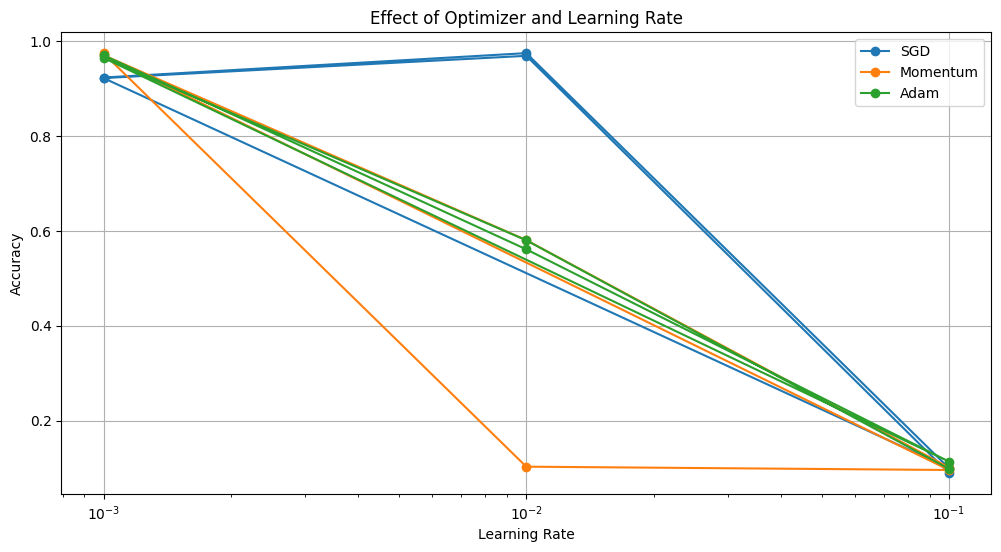

In [1]:
# FCNN Results
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Optimizer": ["SGD", "SGD", "SGD", "SGD", "SGD", "SGD",
                  "Momentum", "Momentum", "Momentum", "Momentum", "Momentum", "Momentum",
                  "Adam", "Adam", "Adam", "Adam", "Adam", "Adam"],
    "Layer Config": ["[784, 128, 64, 10]", "[784, 128, 64, 10]", "[784, 128, 64, 10]",
                     "[784, 256, 128, 10]", "[784, 256, 128, 10]", "[784, 256, 128, 10]",
                     "[784, 128, 64, 10]", "[784, 128, 64, 10]", "[784, 128, 64, 10]",
                     "[784, 256, 128, 10]", "[784, 256, 128, 10]", "[784, 256, 128, 10]",
                     "[784, 128, 64, 10]", "[784, 128, 64, 10]", "[784, 128, 64, 10]",
                     "[784, 256, 128, 10]", "[784, 256, 128, 10]", "[784, 256, 128, 10]"],
    "Learning Rate": [0.1, 0.01, 0.001, 0.1, 0.01, 0.001,
                      0.1, 0.01, 0.001, 0.1, 0.01, 0.001,
                      0.1, 0.01, 0.001, 0.1, 0.01, 0.001],
    "Accuracy": [0.0892, 0.9691, 0.9222, 0.0996, 0.9748, 0.9233,
                 0.101, 0.5805, 0.9704, 0.0958, 0.1028, 0.9744,
                 0.0982, 0.5802, 0.9648, 0.1135, 0.5611, 0.9703]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
for optimizer in df["Optimizer"].unique():
    subset = df[df["Optimizer"] == optimizer]
    plt.plot(subset["Learning Rate"], subset["Accuracy"], marker='o', label=f"{optimizer}")

plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Optimizer and Learning Rate")
plt.legend()
plt.grid()
plt.show()

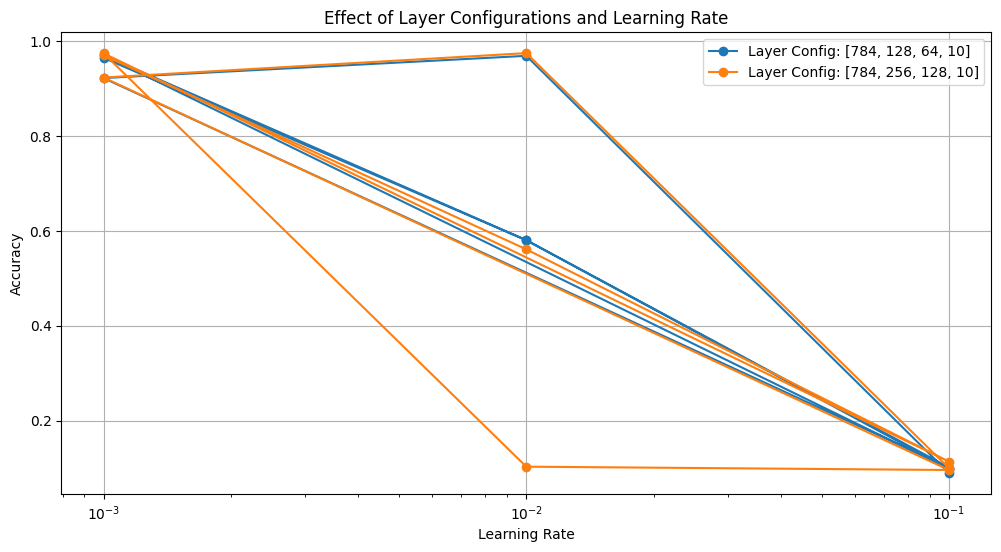

In [8]:
plt.figure(figsize=(12, 6))
for config in df["Layer Config"].unique():
    subset = df[df["Layer Config"] == config]
    plt.plot(subset["Learning Rate"], subset["Accuracy"], marker='o', label=f"Layer Config: {config}")

plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Layer Configurations and Learning Rate")
plt.legend()
plt.grid()
plt.show()

In [5]:
# Data Sampling
sampling_ratio = 0.1

def sample_dataset(dataset, ratio):
    indices = np.random.choice(len(dataset), int(len(dataset) * ratio), replace=False)
    return Subset(dataset, indices)

def train_loader_template(batch_size):
    train_dataset = datasets.MNIST('dataset/', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.5,), std=(0.5,))
                                   ]))
    sampled_dataset = sample_dataset(train_dataset, sampling_ratio)
    return DataLoader(sampled_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('dataset/', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size,
    shuffle=True
)

In [6]:
# Max Pooling
def maxpool2d(image, pool_size=2, stride=2):
    n, h, w, c = image.shape
    h_out = (h - pool_size) // stride + 1
    w_out = (w - pool_size) // stride + 1
    pooled = np.zeros((n, h_out, w_out, c))

    for i in range(h_out):
        for j in range(w_out):
            h_start, h_end = i * stride, i * stride + pool_size
            w_start, w_end = j * stride, j * stride + pool_size
            pooled[:, i, j, :] = np.max(image[:, h_start:h_end, w_start:w_end, :], axis=(1, 2))

    return pooled

In [13]:
# Convolutional Neural Network
class CNN:
    def __init__(self, learning_rate, optimizer):
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.momentum_cache = {}
        self.adam_cache = {}
        self.timestep = 0
        self.conv1_filters = 32
        self.conv2_filters = 64
        self.fc_input_dim = 64 * 5 * 5
        self.fc_hidden_dim = 128
        self.fc_output_dim = 10
        self.conv1_kernel = self.initialize_weights((3, 3, 1, self.conv1_filters))
        self.conv1_bias = np.zeros((self.conv1_filters,))
        self.conv2_kernel = self.initialize_weights((3, 3, self.conv1_filters, self.conv2_filters))
        self.conv2_bias = np.zeros((self.conv2_filters,))
        self.fc1_weights = self.initialize_weights((self.fc_input_dim, self.fc_hidden_dim))
        self.fc1_bias = np.zeros((self.fc_hidden_dim,))
        self.fc2_weights = self.initialize_weights((self.fc_hidden_dim, self.fc_output_dim))
        self.fc2_bias = np.zeros((self.fc_output_dim,))

    def initialize_weights(self, shape):
        return np.random.randn(*shape) * np.sqrt(2 / shape[0])

    def convolution(self, x, kernel, bias):
        n, h, w, c = x.shape
        kh, kw, _, nf = kernel.shape
        h_out = h - kh + 1
        w_out = w - kw + 1
        conv_out = np.zeros((n, h_out, w_out, nf))

        for i in range(h_out):
            for j in range(w_out):
                patch = x[:, i:i+kh, j:j+kw, :]
                for f in range(nf):
                    conv_out[:, i, j, f] = np.sum(patch * kernel[..., f], axis=(1, 2, 3)) + bias[f]
        return conv_out

    def forward(self, x):
        # Conv1 -> ReLU -> MaxPool
        self.conv1_out = self.convolution(x, self.conv1_kernel, self.conv1_bias)
        self.relu1_out = relu(self.conv1_out)
        self.pool1_out = maxpool2d(self.relu1_out)

        # Conv2 -> ReLU -> MaxPool
        self.conv2_out = self.convolution(self.pool1_out, self.conv2_kernel, self.conv2_bias)
        self.relu2_out = relu(self.conv2_out)
        self.pool2_out = maxpool2d(self.relu2_out)

        # Flatten
        self.flat_out = self.pool2_out.reshape(self.pool2_out.shape[0], -1)

        # Fully Connected Layer 1 -> ReLU
        self.fc1_out = relu(np.dot(self.flat_out, self.fc1_weights) + self.fc1_bias)

        # Fully Connected Layer 2 -> Softmax
        self.fc2_out = softmax(np.dot(self.fc1_out, self.fc2_weights) + self.fc2_bias)

        return self.fc2_out

    def backward(self, x, y):
        output_error = cross_entropy_derivative(self.fc2_out, y)
        d_fc2_weights = np.dot(self.fc1_out.T, output_error)
        d_fc2_bias = np.sum(output_error, axis=0)
        fc1_error = np.dot(output_error, self.fc2_weights.T) * relu_derivative(self.fc1_out)
        d_fc1_weights = np.dot(self.flat_out.T, fc1_error)
        d_fc1_bias = np.sum(fc1_error, axis=0)

        if self.optimizer == "SGD":
            self.fc2_weights -= self.learning_rate * d_fc2_weights
            self.fc2_bias -= self.learning_rate * d_fc2_bias
            self.fc1_weights -= self.learning_rate * d_fc1_weights
            self.fc1_bias -= self.learning_rate * d_fc1_bias
        elif self.optimizer == "Momentum":
            if not self.momentum_cache:
                self.momentum_cache = {
                    "fc2_weights": np.zeros_like(d_fc2_weights),
                    "fc2_bias": np.zeros_like(d_fc2_bias),
                    "fc1_weights": np.zeros_like(d_fc1_weights),
                    "fc1_bias": np.zeros_like(d_fc1_bias),
                }
            gamma = 0.9
            for param in ["fc2_weights", "fc2_bias", "fc1_weights", "fc1_bias"]:
                grad = locals()["d_" + param]
                self.momentum_cache[param] = gamma * self.momentum_cache[param] + self.learning_rate * grad
                setattr(self, param, getattr(self, param) - self.momentum_cache[param])
        elif self.optimizer == "Adam":
            beta1, beta2 = 0.9, 0.999
            epsilon = 1e-8
            self.timestep += 1
            if not self.adam_cache:
                self.adam_cache = {
                    "m": {"fc2_weights": np.zeros_like(d_fc2_weights), "fc2_bias": np.zeros_like(d_fc2_bias),
                           "fc1_weights": np.zeros_like(d_fc1_weights), "fc1_bias": np.zeros_like(d_fc1_bias)},
                    "v": {"fc2_weights": np.zeros_like(d_fc2_weights), "fc2_bias": np.zeros_like(d_fc2_bias),
                           "fc1_weights": np.zeros_like(d_fc1_weights), "fc1_bias": np.zeros_like(d_fc1_bias)},
                }
            for param in ["fc2_weights", "fc2_bias", "fc1_weights", "fc1_bias"]:
                grad = locals()["d_" + param]
                self.adam_cache["m"][param] = beta1 * self.adam_cache["m"][param] + (1 - beta1) * grad
                self.adam_cache["v"][param] = beta2 * self.adam_cache["v"][param] + (1 - beta2) * (grad ** 2)

                m_hat = self.adam_cache["m"][param] / (1 - beta1 ** self.timestep)
                v_hat = self.adam_cache["v"][param] / (1 - beta2 ** self.timestep)

                setattr(self, param, getattr(self, param) - self.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon))

    def train(self, x, y):
        predictions = self.forward(x)
        self.backward(x, y)
        return cross_entropy_loss(predictions, y)


In [12]:
# CNN Grid Search
# batch_sizes = [16, 32]
batch_sizes = [32]

# learning_rates = [0.1, 0.01, 0.001]
learning_rates = [0.1]

# epochs_list = [3, 5, 10]
epochs_list = [5]

# optimizers = ["SGD", "Momentum", "Adam"]
optimizers = ["SGD"]

best_accuracy = 0
best_params = {}

for optimizer in optimizers:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                print(f"Training with optimizer={optimizer}, batch_size={batch_size}, learning_rate={lr}, epochs={epochs}")

                train_loader = train_loader_template(batch_size)
                model = CNN(lr, optimizer)

                for epoch in range(epochs):
                    epoch_loss = 0
                    for batch_idx, (data, target) in enumerate(train_loader):
                        data = data.numpy().reshape(-1, 28, 28, 1)  # Convert to Numpy
                        target = np.eye(10)[target.numpy()]         # One-hot encoding

                        loss = model.train(data, target)
                        epoch_loss += loss

                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

                predictions = []
                all_labels = []

                for batch_idx, (data, target) in enumerate(test_loader):
                    data = data.numpy().reshape(-1, 28, 28, 1)
                    target = target.numpy()

                    pred = model.forward(data)
                    predictions.extend(np.argmax(pred, axis=1))
                    all_labels.extend(target)

                accuracy = accuracy_score(all_labels, predictions)
                print(f"Accuracy: {accuracy}")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {"optimizer": optimizer, "batch_size": batch_size, "learning_rate": lr, "epochs": epochs}

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


Training with optimizer=SGD, batch_size=32, learning_rate=0.1, epochs=5
Epoch 1/5, Loss: 2.81835417526141
Epoch 2/5, Loss: 2.3268884494125817
Epoch 3/5, Loss: 2.3257854051007025
Epoch 4/5, Loss: 2.326749801212612
Epoch 5/5, Loss: 2.331411148250711
Accuracy: 0.0982
Best Parameters: {'optimizer': 'SGD', 'batch_size': 32, 'learning_rate': 0.1, 'epochs': 5}
Best Accuracy: 0.0982


In [ ]:
# Recurrent Neural Network
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, optimizer):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.Wxh = np.random.randn(input_size, hidden_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(hidden_size, output_size) * 0.01
        self.bh = np.zeros((1, hidden_size))
        self.by = np.zeros((1, output_size))

        if optimizer == "Momentum" or optimizer == "Adam":
            self.momentum_cache = {
                "Wxh": np.zeros_like(self.Wxh),
                "Whh": np.zeros_like(self.Whh),
                "Why": np.zeros_like(self.Why),
                "bh": np.zeros_like(self.bh),
                "by": np.zeros_like(self.by),
            }
        if optimizer == "Adam":
            self.adam_cache = {
                "m": {"Wxh": np.zeros_like(self.Wxh), "Whh": np.zeros_like(self.Whh), "Why": np.zeros_like(self.Why), "bh": np.zeros_like(self.bh), "by": np.zeros_like(self.by)},
                "v": {"Wxh": np.zeros_like(self.Wxh), "Whh": np.zeros_like(self.Whh), "Why": np.zeros_like(self.Why), "bh": np.zeros_like(self.bh), "by": np.zeros_like(self.by)},
            }
            self.timestep = 0

    def forward(self, x):
        self.hidden_states = []
        self.hidden = np.zeros((x.shape[0], self.hidden_size))
        self.inputs = x

        for t in range(x.shape[1]):
            xt = x[:, t, :]
            self.hidden = np.tanh(np.dot(xt, self.Wxh) + np.dot(self.hidden, self.Whh) + self.bh)
            self.hidden_states.append(self.hidden)

        self.output = softmax(np.dot(self.hidden, self.Why) + self.by)
        return self.output

    def backward(self, y):
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dbh = np.zeros_like(self.bh)
        output_error = self.output - y
        dWhy += np.dot(self.hidden.T, output_error)
        dby += np.sum(output_error, axis=0, keepdims=True)

        dh_next = np.zeros_like(self.hidden)
        for t in reversed(range(len(self.hidden_states))):
            dh = np.dot(output_error, self.Why.T) + dh_next
            dh_raw = (1 - self.hidden_states[t] ** 2) * dh
            dWxh += np.dot(self.inputs[:, t, :].T, dh_raw)
            dWhh += np.dot(self.hidden_states[t - 1].T, dh_raw) if t > 0 else 0
            dbh += np.sum(dh_raw, axis=0, keepdims=True)
            dh_next = np.dot(dh_raw, self.Whh.T)

        self.update_weights(dWxh, dWhh, dWhy, dbh, dby)

    def update_weights(self, dWxh, dWhh, dWhy, dbh, dby):
        if self.optimizer == "SGD":
            self.Wxh -= self.learning_rate * dWxh
            self.Whh -= self.learning_rate * dWhh
            self.Why -= self.learning_rate * dWhy
            self.bh -= self.learning_rate * dbh
            self.by -= self.learning_rate * dby

        elif self.optimizer == "Momentum":
            gamma = 0.9
            for param, grad in zip(["Wxh", "Whh", "Why", "bh", "by"], [dWxh, dWhh, dWhy, dbh, dby]):
                self.momentum_cache[param] = gamma * self.momentum_cache[param] + self.learning_rate * grad
                setattr(self, param, getattr(self, param) - self.momentum_cache[param])

        elif self.optimizer == "Adam":
            beta1, beta2 = 0.9, 0.999
            epsilon = 1e-8
            self.timestep += 1

            for param, grad in zip(["Wxh", "Whh", "Why", "bh", "by"], [dWxh, dWhh, dWhy, dbh, dby]):
                self.adam_cache["m"][param] = beta1 * self.adam_cache["m"][param] + (1 - beta1) * grad
                self.adam_cache["v"][param] = beta2 * self.adam_cache["v"][param] + (1 - beta2) * (grad ** 2)
                m_hat = self.adam_cache["m"][param] / (1 - beta1 ** self.timestep)
                v_hat = self.adam_cache["v"][param] / (1 - beta2 ** self.timestep)

                setattr(self, param, getattr(self, param) - self.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon))

    def train(self, x, y):
        predictions = self.forward(x)
        loss = cross_entropy_loss(predictions, y)
        self.backward(y)
        return loss

    def predict(self, x):
        predictions = self.forward(x)
        return np.argmax(predictions, axis=1)


In [ ]:
# RNN Grid Search
hidden_sizes = [64, 128]
learning_rates = [0.1, 0.01, 0.001]
optimizers = ["SGD", "Momentum", "Adam"]
epochs = 5

best_accuracy = 0
best_params = {}

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            print(f"Training with hidden_size={hidden_size}, learning_rate={learning_rate}, optimizer={optimizer}")

            model = RNN(28, hidden_size, 10, learning_rate, optimizer)

            for epoch in range(epochs):
                epoch_loss = 0
                for batch_idx, (data, target) in enumerate(train_loader):
                    data = data.numpy().reshape(-1, 28, 28)
                    target_onehot = np.eye(10)[target.numpy()]

                    loss = model.train(data, target_onehot)
                    epoch_loss += loss

                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

            all_predictions = []
            all_labels = []
            for batch_idx, (data, target) in enumerate(test_loader):
                data = data.numpy().reshape(-1, 28, 28)
                predictions = model.predict(data)

                all_predictions.extend(predictions)
                all_labels.extend(target.numpy())

            accuracy = accuracy_score(all_labels, all_predictions)
            print(f"Test Accuracy: {accuracy}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"hidden_size": hidden_size, "learning_rate": learning_rate, "optimizer": optimizer}

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)


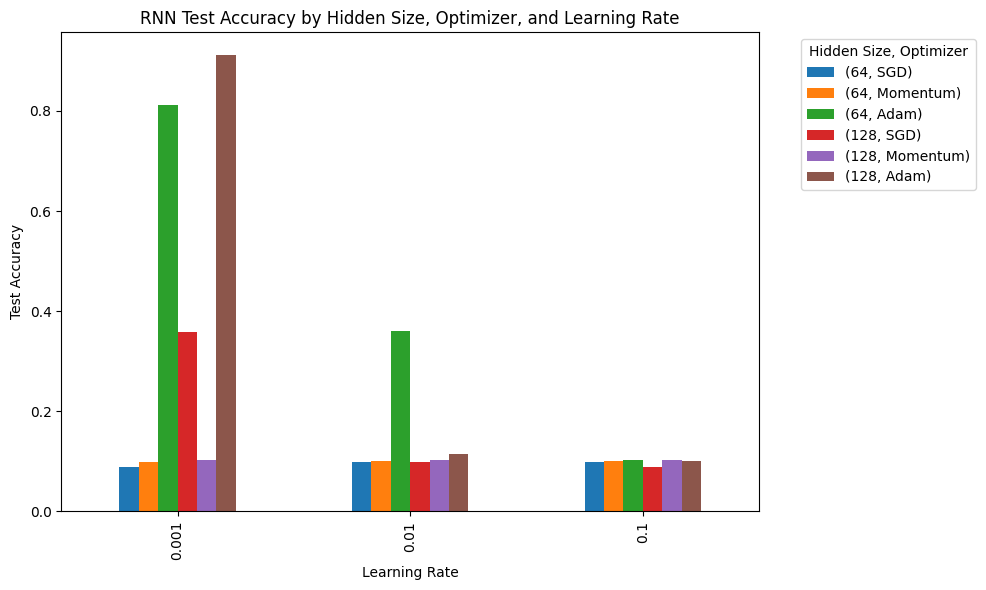

    hidden_size  learning_rate optimizer  test_accuracy  final_loss
0            64          0.100       SGD         0.0982     15.7642
1            64          0.100  Momentum         0.1009     16.2050
2            64          0.100      Adam         0.1028      2.8630
3            64          0.010       SGD         0.0974      4.1622
4            64          0.010  Momentum         0.1009     13.7404
5            64          0.010      Adam         0.3602      1.8060
6            64          0.001       SGD         0.0892      2.3178
7            64          0.001  Momentum         0.0974      2.4670
8            64          0.001      Adam         0.8123      0.6148
9           128          0.100       SGD         0.0892     16.2079
10          128          0.100  Momentum         0.1028     16.4497
11          128          0.100      Adam         0.1010      3.5843
12          128          0.010       SGD         0.0982     10.0848
13          128          0.010  Momentum        

In [7]:
# RNN Results

data = {
    "hidden_size": [64] * 9 + [128] * 9,
    "learning_rate": [0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001] * 2,
    "optimizer": ["SGD", "Momentum", "Adam"] * 6,
    "test_accuracy": [
        0.0982, 0.1009, 0.1028, 0.0974, 0.1009, 0.3602,
        0.0892, 0.0974, 0.8123, 0.0892, 0.1028, 0.101,
        0.0982, 0.1032, 0.1135, 0.3585, 0.1026, 0.9115
    ],
    "final_loss": [
        15.7642, 16.2050, 2.8630, 4.1622, 13.7404, 1.8060,
        2.3178, 2.4670, 0.6148, 16.2079, 16.4497, 3.5843,
        10.0848, 15.4953, 2.4401, 2.1590, 2.6558, 0.4374
    ]
}

df = pd.DataFrame(data)

pivot_table = df.pivot(index="learning_rate", columns=["hidden_size", "optimizer"], values="test_accuracy")

pivot_table.plot(kind="bar", figsize=(10, 6), legend=True)
plt.title("RNN Test Accuracy by Hidden Size, Optimizer, and Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.legend(title="Hidden Size, Optimizer", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(df)
